In [1]:
import pandas as pd
import numpy as np
import re
import gzip
import json
import swifter
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, opinion_lexicon
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk import pos_tag

# === NLTK Setup ===
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab')   # needed by newer NLTK
nltk.download('averaged_perceptron_tagger')
nltk.download('opinion_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_percept

True

In [2]:
# === 1) Load data ===
metadata_path = r"C:\Master\datasets\meta_Cell_Phones_and_Accessories.json.gz"
metadata_df = pd.read_json(metadata_path, lines=True, compression='gzip')

reviews_path = r"C:\Master\datasets\Cell_Phones_and_Accessories.json.gz"

def read_limited_json_gz(file_path, limit=1_000_000):
    data = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= limit:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)

reviews_df = read_limited_json_gz(reviews_path, limit=1_000_000)
df = pd.merge(reviews_df, metadata_df, on='asin', how='inner')

# Drop unused columns
columns_to_drop = [
    "reviewTime", "unixReviewTime", "vote", "rank", "also_view", "details",
    "similar_item", "date", "price", "imageURL", "imageURLHighRes","details",
    "image", "tech1", "also_buy", "tech2", "fit", "style", "category",
    "main_cat", "feature", "description"
]
df = df.drop(columns=columns_to_drop, errors='ignore')

# Fill missing & dedupe
df['reviewerName'] = df['reviewerName'].fillna('NAN')
df['reviewText'] = df['reviewText'].fillna('NAN')
df['summary'] = df['summary'].fillna('NAN')
df = df.drop_duplicates(subset='reviewText', keep='first')

In [3]:
# === 2) Cleaning with NEGATION handling ===
stop_words = set(stopwords.words('english'))
# keep negators in text, so remove them from stopwords if present
for w in ['not', 'no', 'never']:
    if w in stop_words:
        stop_words.remove(w)

tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
NEGATORS = {'not', 'no', 'never'}

def expand_simple_contractions(t: str) -> str:
    # handle n't → not
    t = re.sub(r"n['’]t\b", " not", t)
    # common ones
    t = re.sub(r"\b(can)['’]t\b", "can not", t)
    t = re.sub(r"\b(won)['’]t\b", "will not", t)
    t = re.sub(r"\b(shan)['’]t\b", "shall not", t)
    return t

def apply_negation_scope(tokens, window=2):
    out = []
    i = 0
    while i < len(tokens):
        tok = tokens[i]
        out.append(tok)
        if tok in NEGATORS:
            # prefix the next `window` tokens with neg_
            for j in range(1, window+1):
                if i + j < len(tokens):
                    out.append('neg_' + tokens[i + j])
            i += window  # we already appended next tokens with neg_
        i += 1
    return out

def clean_text(text):
    text = str(text).lower()
    text = expand_simple_contractions(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    # keep words only; punctuation removed AFTER contractions
    text = re.sub(r"[^a-z\s]", " ", text)
    raw_tokens = tokenizer.tokenize(text)

    # lemmatize & remove stopwords except negators
    tokens = [lemmatizer.lemmatize(w) for w in raw_tokens if (w not in stop_words and len(w) > 2) or (w in NEGATORS)]
    # apply negation scope (creates tokens like neg_good, neg_like)
    tokens = apply_negation_scope(tokens, window=2)

    return " ".join(tokens)

df['clean_review'] = df['reviewText'].astype(str).swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/928301 [00:00<?, ?it/s]

In [4]:
# Drop missing/empty clean_review
df = df.dropna(subset=['clean_review'])
df = df[df['clean_review'].str.strip() != '']

In [5]:
# === 3) VADER weak labels (for supervised target) ===
sia = SentimentIntensityAnalyzer()
def get_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'
df['sentiment'] = df['reviewText'].apply(get_sentiment)


In [6]:
# === 4) Balance ===
df_majority = df[df['sentiment'] == 'neutral']
df_pos = df[df['sentiment'] == 'positive']
df_neg = df[df['sentiment'] == 'negative']

df_pos_up = resample(df_pos, replace=True, n_samples=len(df_majority), random_state=42)
df_neg_up = resample(df_neg, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_pos_up, df_neg_up])


In [7]:
# === 5) Feature Transformers ===
class VaderSentimentFeat(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.analyzer = SentimentIntensityAnalyzer()
    def fit(self, X, y=None): return self
    def transform(self, X):
        scores = [self.analyzer.polarity_scores(text)['compound'] for text in X]
        scaled = [(s + 1) / 2 for s in scores]  # [-1,1] -> [0,1]
        return np.array(scaled).reshape(-1, 1)

class POSFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        pos_data = []
        for text in X:
            tokens = word_tokenize(text)
            tagged = pos_tag(tokens)
            total = len(tagged) if tagged else 1
            nouns = sum(1 for _, tag in tagged if tag.startswith('NN'))
            verbs = sum(1 for _, tag in tagged if tag.startswith('VB'))
            adjs  = sum(1 for _, tag in tagged if tag.startswith('JJ'))
            advs  = sum(1 for _, tag in tagged if tag.startswith('RB'))
            pos_data.append([nouns/total, verbs/total, adjs/total, advs/total])
        return np.array(pos_data)

class ReviewFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        feats = []
        for text in X:
            words = text.split()
            length = len(words)
            avg_word_len = np.mean([len(w) for w in words]) if length else 0
            exclamations = text.count('!')
            uppercase_words = sum(1 for w in words if w.isupper())
            feats.append([length, avg_word_len, exclamations, uppercase_words])
        return np.array(feats)

# NEW: Polarity word counts (from opinion_lexicon)
pos_lex = set(opinion_lexicon.positive())
neg_lex = set(opinion_lexicon.negative())

class PolarityCountFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        rows = []
        for text in X:
            toks = text.split()
            length = len(toks) if len(toks) > 0 else 1
            pos_cnt = sum(1 for w in toks if w in pos_lex or (w.startswith('neg_') and w[4:] in neg_lex))  # neg_negword flips
            neg_cnt = sum(1 for w in toks if w in neg_lex or (w.startswith('neg_') and w[4:] in pos_lex))
            rows.append([pos_cnt, neg_cnt, pos_cnt/length, neg_cnt/length])
        return np.array(rows)


In [8]:
# === 6) Split ===
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['clean_review'],
    df_balanced['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['sentiment']
)

In [9]:
# === 7) Feature Union (+ normalization where needed) ===
combined_features = FeatureUnion([
    ('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True,
                              max_features=30000, ngram_range=(1, 3), min_df=1, max_df=0.85)),
    ('vader', make_pipeline(VaderSentimentFeat(), MinMaxScaler())),
    ('pos', make_pipeline(POSFeatures(), MinMaxScaler())),
    ('review_feats', make_pipeline(ReviewFeatures(), MinMaxScaler())),
    ('polarity', make_pipeline(PolarityCountFeatures(), MinMaxScaler()))
])

In [10]:
# === 8) ComplementNB pipeline & search ===
nb_pipeline = Pipeline([
    ('features', combined_features),
    ('nb', ComplementNB())
])

nb_param_grid = {
    'nb__alpha': [0.1, 0.5, 1.0],
    'nb__fit_prior': [True, False]
}

grid = GridSearchCV(nb_pipeline, nb_param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=1)
grid.fit(X_train, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('tfidf',
                                                                        TfidfVectorizer(max_df=0.85,
                                                                                        max_features=30000,
                                                                                        ngram_range=(1,
                                                                                                     3),
                                                                                        stop_words='english',
                                                                                        sublinear_tf=True)),
                                                                       ('vader',
                                                                        Pipeline(steps=[('vadersentimentfeat',
                                                                                         VaderSentimentFeat()),
                                                                                        ('minmaxscaler',
                                                                                         MinMaxScaler())])),
                                                                       ('pos',
                                                                        Pipeline(steps=[('posfeatures',
                                                                                         POSFea...
                                                                                         MinMaxScaler())])),
                                                                       ('review_feats',
                                                                        Pipeline(steps=[('reviewfeatures',
                                                                                         ReviewFeatures()),
                                                                                        ('minmaxscaler',
                                                                                         MinMaxScaler())])),
                                                                       ('polarity',
                                                                        Pipeline(steps=[('polaritycountfeatures',
                                                                                         PolarityCountFeatures()),
                                                                                        ('minmaxscaler',
                                                                                         MinMaxScaler())]))])),
                                       ('nb', ComplementNB())]),
             n_jobs=1,
             param_grid={'nb__alpha': [0.1, 0.5, 1.0],
                         'nb__fit_prior': [True, False]},
             scoring='accuracy', verbose=1)


Best Parameters: {'nb__alpha': 1.0, 'nb__fit_prior': True}

=== Accuracy ===
0.7423

=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.71      0.77      0.74     11848
     neutral       0.80      0.62      0.70     11848
    positive       0.73      0.84      0.78     11848

    accuracy                           0.74     35544
   macro avg       0.75      0.74      0.74     35544
weighted avg       0.75      0.74      0.74     35544


=== Confusion Matrix ===


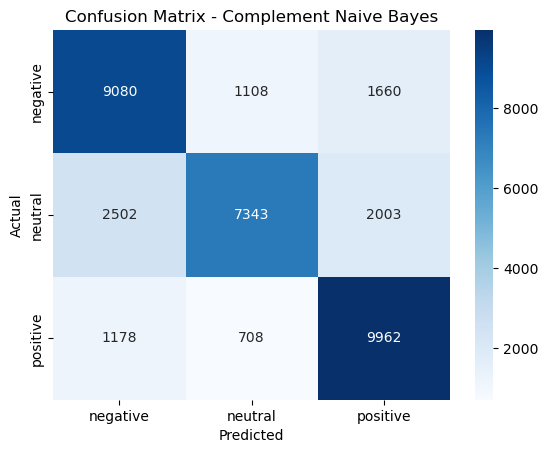

In [11]:
# === 9) Evaluation ===
print("\nBest Parameters:", grid.best_params_)
y_pred = grid.predict(X_test)

print("\n=== Accuracy ===")
print(f"{accuracy_score(y_test, y_pred):.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid.classes_, yticklabels=grid.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Complement Naive Bayes')
plt.show()

In [12]:
df_balanced

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,title,brand,clean_review,sentiment
1,1.0,True,AN04BLRG7BD8I,7391002801,J. Inman,Had this for 2 weeks. Had to replace screen p...,Outer ring very flimsy.,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,week replace screen protector outer ring snapp...,neutral
13,5.0,True,A107O6W0Q98CAT,7391002801,Suzanne Henderson #1410864,met expectations,met expectations,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,met expectation,neutral
17,5.0,True,A1EHXZBPIPARC2,7391002801,Guillermo Chavez,Excelente!!!,Five Stars,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,excelente,neutral
20,5.0,True,A3D509XLLX9A4G,7391002801,Heidi,Product arrived on time exactly as described.,Great seller!!!,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,product arrived time exactly described,neutral
28,2.0,True,A387RPGAX752UK,7508492919,RayRay,I loved the girly look if it when it arrived. ...,Poor Quality,MinisDesign 3d Bling Crystal Bow Transparent C...,ELEGANI,loved girly look arrived definitely gave ooooo...,neutral
...,...,...,...,...,...,...,...,...,...,...,...
140155,4.0,True,A1AVANVFF4K9E0,B001MRZY3S,RealHappens,Purchased this phone for fiance in Philippines...,Lasted 2 years...then smoked!,LG KP500 Cookie Unlocked Phone with 3.2 MP Cam...,LG,purchased phone fiance philippine worked outst...,negative
986408,3.0,True,A35HT3O3400KNH,B008HU23PA,Teresa Johnson,to hard to get it off,Three Stars,Blue Hard Case and Black Silicone Skin Dual Co...,Leegoal,hard get,negative
159639,4.0,True,A1JT1SE9WL9BL1,B001ZYMK26,OLD MAN,Has worked fine in the short term price very l...,Four Stars,[2 Pack] Galaxy S9 Plus Screen Protector Tempe...,AVIGOR,worked fine short term price low may order ano...,negative
897842,5.0,True,A2MLOOA7I63Y26,B007PYMG06,Brian J. Stone,"Very strong case. Can be a bit bulky, but that...",Bullet proof,OtterBox Defender Series for Samsung Note Ret...,OtterBox,strong case bit bulky phone large dropped no n...,negative
